In [6]:
'''
Author: chence antonio.chan.cc@outlook.com
Date: 2023-10-17 20:49:32
LastEditors: chence antonio.chan.cc@outlook.com
LastEditTime: 2023-10-18 13:21:51
FilePath: /DatProc/parsing_dev.ipynb
Description: 这是默认设置,请设置`customMade`, 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE
'''
import os
import cv2
import numpy as np
from skimage import io
from dpparser import HeadParser, HeadSegmenter
from dpdetector import HeadDetector, FaceAlignmentDetector
from visualize.vis_2d import show_parsing_result, show_parsing_result_colorized, draw_facial_landmarks, show_image

def crop_head_image(image_data, box):
    # expected input: [x_min, y_min, w, h]
    # print('box', box)
    x_min, y_min, w, h = np.int32(box)
    x_max, y_max = x_min + w, y_min + h
    # print(x_min, y_min, x_max, y_max)
    top_size, bottom_size, left_size, right_size = 0, 0, 0, 0
    if x_min < 0:
        left_size = abs(x_min)
        x_min = 0
    if y_min < 0:
        top_size = abs(y_min)
        y_min = 0
    if x_max > image_data.shape[1]:
        right_size = abs(x_max - image_data.shape[1])
        x_max = image_data.shape[1]
    if y_max > image_data.shape[0]:
        bottom_size = abs(y_max - image_data.shape[0])
        y_max = image_data.shape[0]
    # print(top_size, bottom_size, left_size, right_size)
    crop_img = image_data[y_min:y_max, x_min:x_max]
    # print(crop_img.shape)
    if top_size + bottom_size + left_size + right_size != 0:
        crop_msk = np.ones_like(crop_img) * 255
        crop_img = cv2.copyMakeBorder(crop_img, top_size, bottom_size, left_size, right_size,
                                        borderType=cv2.BORDER_REFLECT)
        crop_msk = cv2.copyMakeBorder(crop_msk, top_size, bottom_size, left_size, right_size,
                                        borderType=cv2.BORDER_CONSTANT, value=0)
        size = max(crop_img.shape[:2])
        mask_kernel = int(size*0.02)*2+1
        blur_kernel = int(size*0.03)*2+1
        blur_mask = cv2.blur(crop_msk.astype(np.float32).mean(2), (mask_kernel, mask_kernel)) / 255.0
        blur_mask = blur_mask[..., np.newaxis]  # .astype(np.float32) / 255.0
        blurred_img = cv2.blur(crop_img, (blur_kernel, blur_kernel), 0)
        crop_img = crop_img * blur_mask + blurred_img * (1 - blur_mask)
        crop_img = crop_img.astype(np.uint8)
    # print(crop_img.shape, (h, w))
    assert crop_img.shape[0] == h
    assert crop_img.shape[1] == w
    return crop_img

hed_par = HeadParser()
hed_seg = HeadSegmenter(use_fsam=False)
hed_det = HeadDetector(weights_file='assets/224x224_yolov4_hddet_480x640.onnx', input_width=640, input_height=480, size_thres=512)
flmk_det = FaceAlignmentDetector(score_thres=0.8)


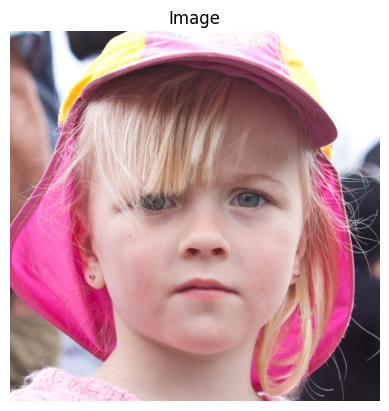

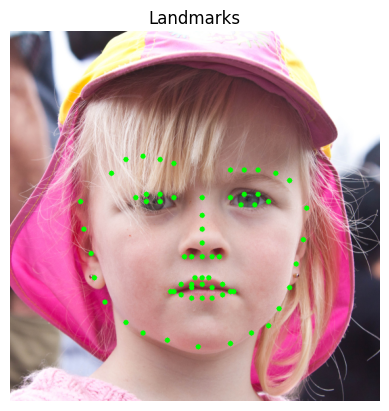

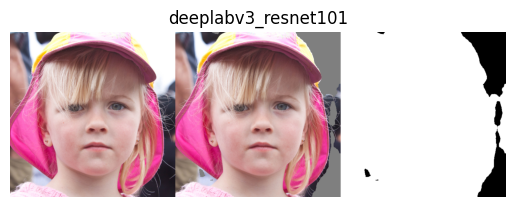


0: 640x640 13 objects, 20.1ms
Speed: 9.4ms preprocess, 20.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


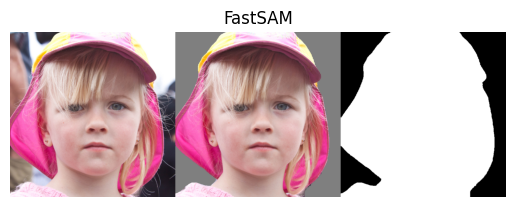


0: 640x640 11 objects, 17.7ms
Speed: 2.9ms preprocess, 17.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


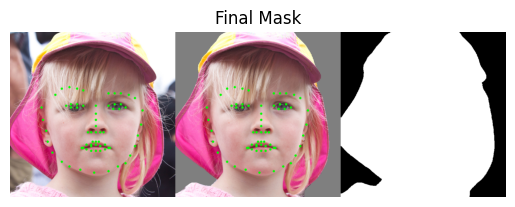

[0, 1, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18]
uint8 15


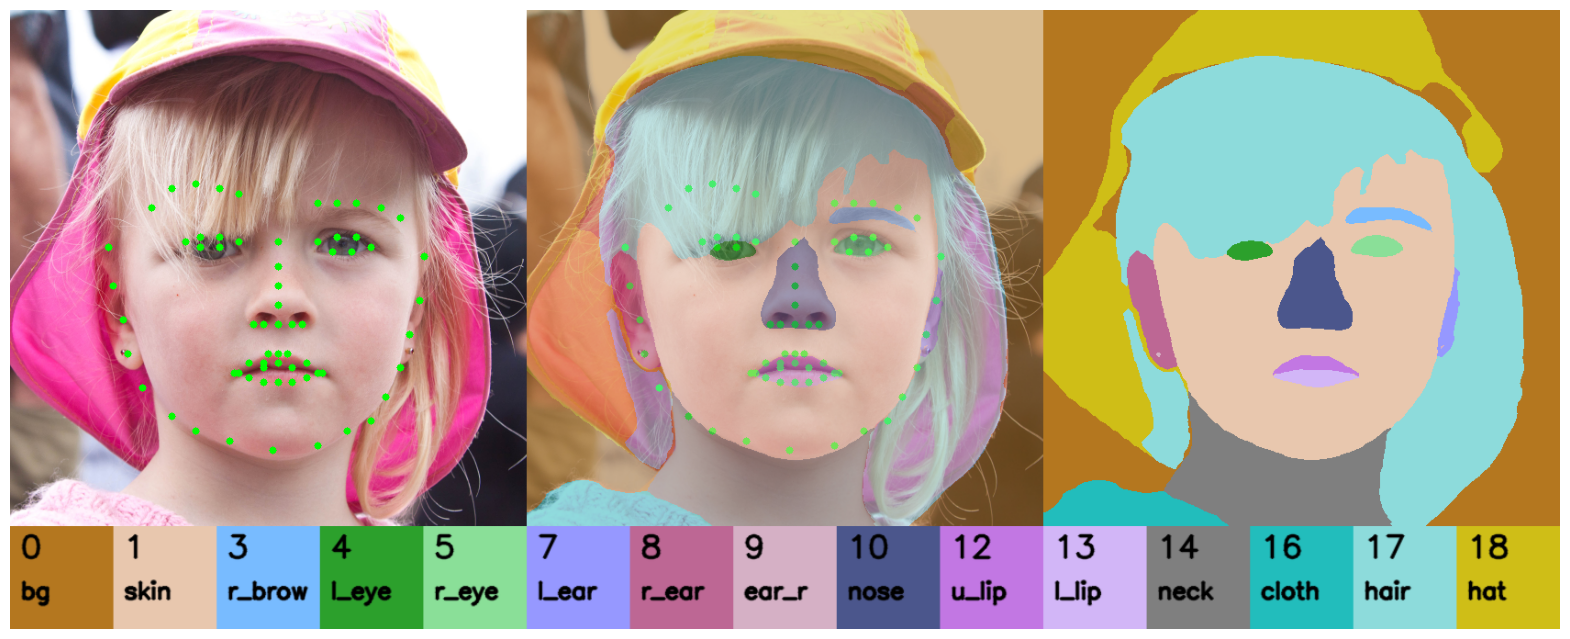

[0, 1, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18]
uint8 15


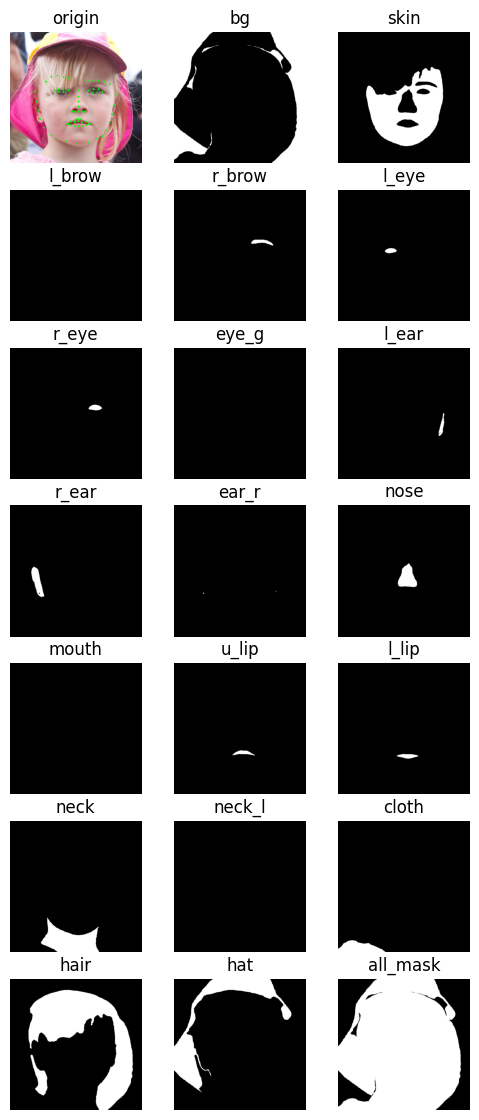

In [2]:
# img_path = "temp/parsing/man_head.jpg"
# img_path = 'temp/samples/images/man.jpg'
# img_path = 'temp/OCD/0001_00/head_image/103.png'
# img_path = 'temp/samples/images/000007.png'
img_path = '/home/chence/Research/3DHeadGen/DatProc/temp/00000/img00000379.png'
# img_path = "temp/samples/samples_bv/head_images/000320_00.png"

img_data = io.imread(img_path)  # RGB uint8 HW3 ndarray
ori_img = img_data.copy()
is_bgr = False
show_image(ori_img, is_bgr, 'Image')

# Detect head box
hed_boxes = hed_det(img_data, isBGR=is_bgr, max_box_num=1)
if hed_boxes is None or hed_boxes.shape[0] == 0:
    raise ValueError('No head detected')
box_np = np.array(hed_boxes[0])  # Coords in Raw Image
head_image = crop_head_image(img_data.copy(), box_np)
landmarks = flmk_det(head_image, isBGR=False, image_upper_left=box_np[:2])  # Coords in Raw Image
if landmarks is not None:
    show_image(draw_facial_landmarks(img_data, landmarks.astype(np.int32)), is_bgr, 'Landmarks')

dlv3_msk = hed_seg.run_dlv3(hed_seg.dlv3_preprocess, hed_seg.dlv3_net, ori_img, is_bgr, True)
box_xyxy = np.array(hed_seg.get_box_xyxy(hed_seg.get_mask_box(dlv3_msk)))
fsam_msk = hed_seg.run_fsam(hed_seg.fsam_net, ori_img, is_bgr, box_xyxy, True)
msk = hed_seg(img_data, is_bgr, True)

# fpp_sem = hed_par.run_fpp(hed_par.fpp_transform, hed_par.fpp_model,
#                           ori_img, is_bgr, False)
# ibug_sem03 = hed_par.run_ibug(hed_par.ibug_model_03, ori_img, is_bgr, False)
# ibug_sem04 = hed_par.run_ibug(hed_par.ibug_model_04, ori_img, is_bgr, False)
sem = hed_par(ori_img, is_bgr, False)
show_parsing_result_colorized(img_data, sem, hed_par.label)
show_parsing_result(img_data, sem, hed_par.label)

In [7]:
import tqdm

img_dir = '/home/chence/Research/3DHeadGen/DatProc/temp/00000'
sample_dir = '/home/chence/Research/3DHeadGen/DatProc/temp/deeplab_v3_vis'
msk_dir = '/home/chence/Research/3DHeadGen/DatProc/temp/00000_mask_FSAM'
# par_dir = 'temp/samples/parsing'
# lmk_dir = 'temp/samples/landmarks'

# os.makedirs(img_dir, exist_ok=True)
# os.makedirs(msk_dir, exist_ok=True)
# os.makedirs(par_dir, exist_ok=True)
# os.makedirs(lmk_dir, exist_ok=True)

for i in tqdm.tqdm(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, i)
    img_data = io.imread(img_path)  # RGB uint8 HW3 ndarray
    ori_img = img_data.copy()
    is_bgr = False

    # # Detect head box
    # hed_boxes = hed_det(img_data, isBGR=is_bgr, max_box_num=1)
    # if hed_boxes is None or hed_boxes.shape[0] == 0:
    #     pass
    # else:
    #     box_np = np.array(hed_boxes[0])  # Coords in Raw Image
    #     head_image = crop_head_image(img_data.copy(), box_np)
    #     # landmarks = flmk_det(head_image, isBGR=False, image_upper_left=box_np[:2])  # Coords in Raw Image
    #     # if landmarks is not None:
    #     #     np.save(os.path.join(lmk_dir, i.split('.')[0]+'.npy'), landmarks)

    msk = hed_seg(img_data, is_bgr, False)
    io.imsave(os.path.join(msk_dir, i.split('.')[0]+'.png'), msk)
    # sem = hed_par(ori_img, is_bgr, False)
    # io.imsave(os.path.join(par_dir, i.split('.')[0]+'.png'), sem)
    # show_parsing_result_colorized(img_data, sem, hed_par.label)

  4%|▎         | 36/1000 [00:02<01:05, 14.72it/s]/tmp/ipykernel_3547521/840098817.py:32: UserWarning: /home/chence/Research/3DHeadGen/DatProc/temp/00000_mask_FSAM/img00000075.png is a low contrast image
  io.imsave(os.path.join(msk_dir, i.split('.')[0]+'.png'), msk)
 17%|█▋        | 166/1000 [00:10<00:46, 17.99it/s]/tmp/ipykernel_3547521/840098817.py:32: UserWarning: /home/chence/Research/3DHeadGen/DatProc/temp/00000_mask_FSAM/img00000679.png is a low contrast image
  io.imsave(os.path.join(msk_dir, i.split('.')[0]+'.png'), msk)
 44%|████▍     | 440/1000 [00:28<00:34, 16.41it/s]/tmp/ipykernel_3547521/840098817.py:32: UserWarning: /home/chence/Research/3DHeadGen/DatProc/temp/00000_mask_FSAM/img00000505.png is a low contrast image
  io.imsave(os.path.join(msk_dir, i.split('.')[0]+'.png'), msk)
 53%|█████▎    | 534/1000 [00:33<00:30, 15.39it/s]/tmp/ipykernel_3547521/840098817.py:32: UserWarning: /home/chence/Research/3DHeadGen/DatProc/temp/00000_mask_FSAM/img00000128.png is a low contrast